In [73]:
import pandas as pd

# Load the Excel sheet
file_path = 'ITU_regional_global_Key_ICT_indicator_aggregates_Nov_2024_by_urban-rural_area.xlsx'
df = pd.read_excel(file_path, sheet_name='By urban-rural area', header=None)

# Define the column ranges for each coverage area
zone_columns = {
    'Total': (1, 10),
    'Urban': (12, 21),
    'Rural': (23, 32)
}

# Identify the starting row of each indicator block
block_starts = [2 + 16 * i for i in range(5)]

# Extract and reshape each block into a tidy DataFrame
blocks = []
for start in block_starts:
    coverage_type = df.iloc[start, 0]
    for zone, (c_start, c_end) in zone_columns.items():
        # Read years
        years = df.iloc[start, c_start:c_end+1].tolist()
        years = [int(y) for y in years]
        
        # Read data rows
        data = df.iloc[start+1:start+15, [0] + list(range(c_start, c_end+1))].copy()
        data.columns = ['target'] + years
        
        # Melt to long format
        melted = data.melt(id_vars=['target'], var_name='year', value_name='coverage_value')
        melted['coverage_type'] = coverage_type
        melted['coverage_area'] = zone
        blocks.append(melted)

# Concatenate all blocks
df_final = pd.concat(blocks, ignore_index=True)

# Save to CSV
csv_path = 'dataset.csv'
df_final.to_csv(csv_path, index=False)

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Recharger le CSV après reset
df = pd.read_csv('dataset.csv')


In [75]:
df.shape

(2100, 5)

On voit qu'il y a 2100 données et 5 attributs

In [76]:
df.head()

,target,year,coverage_value,coverage_type,coverage_area
0,World,2015,94.9,Population covered by a mobile-cellular networ...,Total
1,Low-income,2015,80.7,Population covered by a mobile-cellular networ...,Total
2,Lower-middle-income,2015,94.4,Population covered by a mobile-cellular networ...,Total
3,Upper-middle-income,2015,96.7,Population covered by a mobile-cellular networ...,Total
4,High-income,2015,98.5,Population covered by a mobile-cellular networ...,Total


In [77]:
print("Informations générales :")
print()
df.info()

Informations générales :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   target          2100 non-null   object 
 1   year            2100 non-null   int64  
 2   coverage_value  1638 non-null   float64
 3   coverage_type   2100 non-null   object 
 4   coverage_area   2100 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 82.2+ KB


### Aperçu (head) et informations (info)
Le format attendu du dataset semble correct avec 4 colonnes (region, year, coverage_value, coverage_type, coverage_area). Cependant, il semble que la variable coverage_value contienne des données manquantes.

In [78]:
print("Statistiques descriptives :")
df.describe()

Statistiques descriptives :


,year,coverage_value
count,2100.000000,1638.000000
mean,2019.500000,72.386502
std,2.872965,31.206524
min,2015.000000,0.000000
25%,2017.000000,53.825000
50%,2019.500000,86.500000
75%,2022.000000,97.500000
max,2024.000000,100.000000


### Interprétation analyse descriptive :
On ne remarque pas d'anomalies à première vue
- les années vont bien de 2015 à 2024
- toutes les couvertures sont bien entre 0 % et 100 %
<p>Il y a donc des couvertures totales (100%) et des couvertures absentes (0%) dans certaines zones ou région ou années pour certains types de couverture réseau.

In [79]:
print("Valeurs manquantes par colonne :")
print(df.isna().sum(), "\n")

Valeurs manquantes par colonne :
target              0
year                0
coverage_value    462
coverage_type       0
coverage_area       0
dtype: int64 



### Valeurs manquantes
On confirme que 462 valeurs de couverture sont manquantes. Nous allons donc procéder à un traitement de ces valeurs manquantes. Les valeurs manquantes concerne la couverture 5G et l'usage d'internet.

### Considérations à prendre en compte
Il est normal que la 5G n'ait aucune donnée avant 2020 car cette technologie n'était pas encore déployée. Nous allons donc imputer les valeurs manquantes par 0.

<p>Cependant, l'usage d'internet existe bel et bien depuis au moins 2015. Nous allons donc procéder à une interpolation pour imputer les valeurs manquantes.

In [80]:
# Sélection des lignes correspondant à la couverture 5G
mask_5g = df['coverage_type'] == 'Population covered by at least a 5G mobile network (%)'

# Remplacement des NaN par 0 uniquement pour la 5G
df.loc[mask_5g, 'coverage_value'] = df.loc[mask_5g, 'coverage_value'].fillna(0)

# (Optionnel) Vérification
print(df.loc[mask_5g, ['target', 'year', 'coverage_value']].head(10))

                                        target  year  coverage_value
1260                                     World  2015             0.0
1261                                Low-income  2015             0.0
1262                       Lower-middle-income  2015             0.0
1263                       Upper-middle-income  2015             0.0
1264                               High-income  2015             0.0
1265          Least Developed Countries (LDCs)  2015             0.0
1266  Land Locked Developing Countries (LLDCs)  2015             0.0
1267     Small Island Developing States (SIDS)  2015             0.0
1268                                    Africa  2015             0.0
1269                                  Americas  2015             0.0


<p>Les valeurs manquantes pour la 5G ont été remplacées par 0.
<p>Il faut encore traiter les valeurs de l'internet

In [82]:
import pandas as pd

# 2. Sélection des données Internet
mask = df['coverage_type'] == 'Percentage of individuals using the Internet, by urban/rural area'
df_inet = df[mask].copy()

# 3. Interpolation linéaire par (pays ; zone)
df_inet['coverage_value'] = (
    df_inet
      .groupby(['target','coverage_area'])['coverage_value']
      .transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
)

# 4. Remise dans le DataFrame d’origine
df.loc[mask, 'coverage_value'] = df_inet['coverage_value']


In [83]:
print("Valeurs manquantes par colonne :")
print(df.isna().sum(), "\n")

Valeurs manquantes par colonne :
target            0
year              0
coverage_value    0
coverage_type     0
coverage_area     0
dtype: int64 



Toutes les valeurs manquantes ont été traitées. Nous pouvons commencer quelques analyses préliminaires.

In [ ]:
df_pivot = df.pivot_table(
    index=['target','coverage_area','year'],
    columns='coverage_type',
    values='coverage_value'
)
corr_matrix = df_pivot.corr()

import seaborn as sns

# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation entre les séries")
plt.show()

# Matrice de corrélation pour les années à partir de 2020
pivot_2020 = df[df['year'] >= 2020].pivot_table(
    index=['target','coverage_area','year'],
    columns='coverage_type',
    values='coverage_value'
)
corr_matrix_2020 = pivot_2020.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_2020, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation entre les séries (années ≥ 2020)")
plt.show()

In [ ]:
# Histogramme de la distribution de 'coverage_value'
plt.figure()
df['coverage_value'].hist()
plt.title('Distribution de la couverture (%)')
plt.xlabel('Couverture (%)')
plt.ylabel('Nombre d\'observations')
plt.show()

# Histogramme de la distribution de 'coverage_value' pour les années à partir de 2020
plt.figure()
df[df['year'] >= 2020]['coverage_value'].hist()
plt.title("Distribution de la couverture (%) (années ≥ 2020)")
plt.xlabel('Couverture (%)')
plt.ylabel("Nombre d'observations")
plt.show()

In [ ]:
# Boxplot de 'coverage_value' par 'zone'
plt.figure()
df.boxplot(column='coverage_value', by='coverage_area')
plt.title('Couverture (%) par type de zone de densité')
plt.suptitle('')
plt.xlabel('Type de densité')
plt.ylabel('Couverture (%)')
plt.show()

### Interprétation des résultats
#### Rural :
La médiane de couverture est plus basse (~45 %) que pour les autres types.
La dispersion est importante : la couverture varie beaucoup selon les régions/années.
#### Urban :
La médiane est nettement plus élevée (~80 %).
Les valeurs sont plus concentrées vers le haut, ce qui indique une meilleure couverture en zone urbaine.
#### Total :
La médiane est intermédiaire (~65 %), ce qui est logique car elle regroupe rural et urbain.
La dispersion est aussi intermédiaire.

On observe dans cette matrice des corrélations de Pearson toutes très proches de 1 :

Les années « adjacentes » (2021–2022, 2022–2023, 2023–2024) présentent les corrélations les plus fortes (~0.999),
La corrélation la plus faible (~0.997) se situe entre 2021 et 2024, c’est-à-dire entre les années les plus éloignées.
Interprétation :

Les régions (et types de zone) conservent quasiment le même rang de couverture d’une année sur l’autre : celles qui sont bien couvertes en 2021 restent bien couvertes en 2024, et inversement.
La progression (ou régression) de la couverture est très lente et homogène : il n’y a pas de « sauts » brutaux entre deux années.
Les inégalités spatiales sont stables dans le temps.
En pratique, cela signifie que la dynamique de couverture est très régulière : on peut modéliser ou prévoir l’évolution 2025 à partir des années précédentes avec un bon degré de confiance, mais il y a peu de variabilité interannuelle.

## Analyse en Composantes Principales (ACP)
L'Analyse en Composantes Principales (ACP), ou PCA en anglais, est une méthode de réduction de dimensionnalité.
Elle transforme un jeu de données de variables corrélées en un nouveau jeu de composantes (axes principaux) non corrélées, ordonnées par la variance expliquée.
Les principales étapes sont :
1. **Standardisation** des données.
2. **Calcul** de la matrice de covariance.
3. **Décomposition en valeurs propres** (eigenvalues) et vecteurs propres (eigenvectors).
4. **Projection** des observations sur les axes principaux.

In [90]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

df_wide.head()

coverage_type,target,coverage_area,year,"Percentage of individuals using the Internet, by urban/rural area",Population covered by a mobile-cellular network (%),Population covered by at least a 3G mobile network (%),Population covered by at least a 5G mobile network (%),Population covered by at least an LTE/WiMAX mobile network (%)
0,Africa,Rural,2015,17.9,78.5,29.7,0.0,0.2
1,Africa,Rural,2016,17.9,79.5,37.4,0.0,1.8
2,Africa,Rural,2017,17.9,79.4,42.0,0.0,3.8
3,Africa,Rural,2018,17.9,81.6,53.1,0.0,8.8
4,Africa,Rural,2019,17.9,81.0,59.1,0.0,14.7


composantes principales :
[[-0.46680086 -0.50304099 -0.50214169 -0.29200141 -0.43776205]
 [-0.3455272  -0.24435138 -0.02955084  0.90187535  0.08155342]
 [-0.36293864 -0.24631661  0.00493435 -0.28275868  0.85301046]
 [ 0.60910872 -0.16214912 -0.71624826  0.14212534  0.26359638]
 [ 0.39996252 -0.77477607  0.48367815 -0.03469795 -0.06784928]] 

variances expliquées :
[3.54219511 0.81508221 0.41872146 0.19105726 0.04487714] 

proportions des variances expliquées :
[0.70675226 0.16262831 0.0835449  0.03812047 0.00895406]


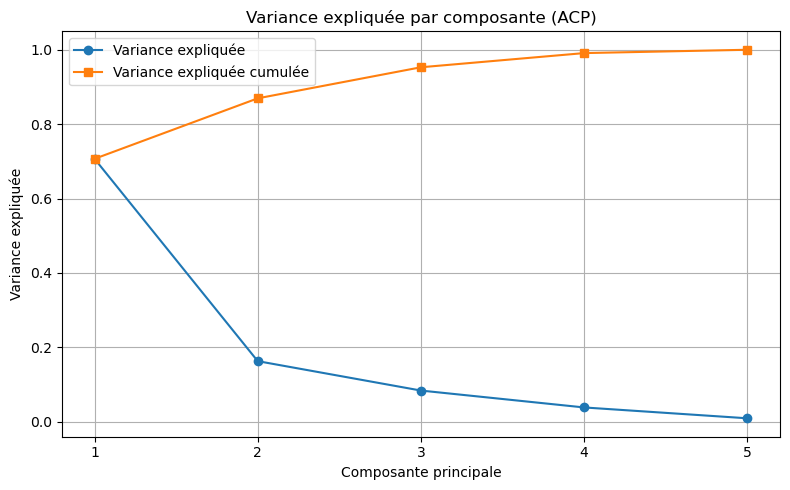

{'variance_expliquee': [0.707, 0.163, 0.084, 0.038, 0.009],
 'variance_expliquee_cumulee': [0.707, 0.869, 0.953, 0.991, 1.0],
 'contributions_PC1': {'Population covered by at least a 5G mobile network (%)': -0.292,
  'Percentage of individuals using the Internet, by urban/rural area': -0.438,
  'Population covered by a mobile-cellular network (%)': -0.467,
  'Population covered by at least an LTE/WiMAX mobile network (%)': -0.502,
  'Population covered by at least a 3G mobile network (%)': -0.503},
 'contributions_PC2': {'Population covered by at least a 5G mobile network (%)': 0.902,
  'Percentage of individuals using the Internet, by urban/rural area': 0.082,
  'Population covered by at least an LTE/WiMAX mobile network (%)': -0.03,
  'Population covered by at least a 3G mobile network (%)': -0.244,
  'Population covered by a mobile-cellular network (%)': -0.346},
 'shape_pivot': (420, 5)}

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Variables quantitatives à inclure dans l'ACP
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]

X = df_wide[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("composantes principales :")
print(pca.components_, "\n")
print("variances expliquées :")
print(pca.explained_variance_, "\n")
print("proportions des variances expliquées :")
print(pca.explained_variance_ratio_)
# Obtenir les proportions des variances expliquées cumulées
#explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par composante (ACP)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables aux composantes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats principaux
{
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape_pivot": X.shape
}

Variance expliquée par chaque composante principale
- PC1 : 70,7 % de la variance totale
- PC2 : 16,3 % (cumulé 86,9 %)
- PC3 : 8,4 %
- PC4 : 3,8 %
- PC5 : 0,9 %

<p>→ Les deux premiers axes résument près de 87 % de l’information !

### Contributions des variables à la première composante principale (PC1)
Plus la valeur absolue est grande, plus la variable "pèse" sur la composante.

| Variable                                                        | Contribution (PC1) |
|-----------------------------------------------------------------|--------------------|
| Population covered by at least a 3G mobile network (%)          | -0.503             |
| Population covered by at least an LTE/WiMAX mobile network (%)  | -0.502             |
| Population covered by a mobile-cellular network (%)             | -0.467             |
| Percentage of individuals using the Internet, by urban/rural area| -0.438             |
| Population covered by at least a 5G mobile network (%)          | -0.292             |

Lecture : PC1 synthétise le niveau global de couverture : plus une cible est “couverte” sur tous les plans, plus sa valeur sur PC1 est faible (négatif car tout est dans le même sens).

### Contributions des variables à la deuxième composante principale (PC2)
| Variable                                                          | Contribution (PC2) |
| ----------------------------------------------------------------- | ------------------ |
| Population covered by at least a 5G mobile network (%)            | +0.902             |
| Percentage of individuals using the Internet, by urban/rural area | +0.082             |
| Population covered by at least an LTE/WiMAX mobile network (%)    | -0.030             |
| Population covered by at least a 3G mobile network (%)            | -0.244             |
| Population covered by a mobile-cellular network (%)               | -0.346             |

Lecture : PC2 oppose fortement la 5G aux autres formes de couverture, ce qui traduit un axe d’évolution technologique.

In [ ]:
# 1. Import des bibliothèques nécessaires pour la PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Préparation des données : pivot avec un feature par type de couverture
# On réutilise df_pivot défini précédemment : index=(target, coverage_area, year), colonnes=coverage_type
# Suppression des lignes avec NaN pour assurer une ACP sans valeurs manquantes
df_pca = df_pivot.dropna()

# 3. Standardisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca.values)

# 4. Calcul de la PCA
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)

# 5. Variance expliquée par chaque composante
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)
print("Variance expliquée par composante :", np.round(explained_var, 3))
print("Variance cumulative :", np.round(cum_var, 3))

In [ ]:
# 6. Scree plot (diagramme des éboulis)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Individuelle')
plt.step(range(1, len(cum_var)+1), cum_var, where='mid', label='Cumulative', color='red')
plt.xlabel('Composante Principale')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot - ACP')
plt.legend()
plt.show()

### Interprétation du Scree Plot
- Les premières composantes expliquent la majeure partie de la variance.
- Le « coude » dans le diagramme peut aider à choisir le nombre optimal de composantes à retenir.

In [ ]:
# 7. Projection des données sur les deux premières composantes principales
pc_df = pd.DataFrame(principalComponents[:, :2],
                     columns=['PC1', 'PC2'],
                     index=df_pca.index)

plt.figure(figsize=(10, 8))
# Coloration par type de zone
sns.scatterplot(x='PC1', y='PC2', data=pc_df.join(pd.Series([idx[1] for idx in df_pca.index],
                                                             index=df_pca.index,
                                                             name='coverage_area')),
                hue='coverage_area', alpha=0.7)
plt.title('Projection sur PC1 et PC2')
plt.xlabel(f"PC1 (6.2f% de variance)" % (explained_var[0]*100))
plt.ylabel(f"PC2 (6.2f% de variance)" % (explained_var[1]*100))
plt.legend()
plt.show()

In [ ]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

# Variables quantitatives à inclure dans l'ACP (exclure 5G et Internet)
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)'
]

X = df_wide[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('ACP 2015-2024 sans 5G ni Internet: variance expliquée')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats
results = {
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape": X.shape
}

results

In [ ]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

# Filtrer sur les années 2021 à 2024
df_subset = df_wide[df_wide['year'].between(2021, 2024)]

# Variables quantitatives à inclure dans l'ACP
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]

X = df_subset[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('ACP sur 2021-2024 : variance expliquée par composante')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables aux composantes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats principaux
results = {
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape_subset": X.shape
}

results

In [ ]:
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]
X = df_wide[features].fillna(0)

# Standardisation et PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Couleurs par zone de couverture
zones = df_wide['coverage_area'].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green']
color_map = dict(zip(zones, colors))

plt.figure(figsize=(8, 6))
for zone in zones:
    idx = df_wide['coverage_area'] == zone
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        c=color_map[zone], label=zone, alpha=0.7, edgecolors='w', s=60
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Projection PCA colorée par zone de couverture')
plt.legend(title="Zone de couverture")
plt.grid()
plt.tight_layout()
plt.show()

import matplotlib.cm as cm

years = sorted(df_wide['year'].unique())
cmap = cm.get_cmap('viridis', len(years))
norm = plt.Normalize(min(years), max(years))

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_wide['year'], cmap=cmap, norm=norm, alpha=0.8, s=60, edgecolors='k'
)
plt.colorbar(sc, label="Année")
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Projection PCA colorée par année')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 31 : PCA étape par étape selon le cours

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Sélection des variables quantitatives
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]
X = df_wide[features].fillna(0)

# 2. Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Créer le modèle PCA (2 composantes principales)
pca = PCA(n_components=2)

# 4. Appliquer la PCA à la base de données
pca.fit(X_scaled)

# 5. Projeter les données
X_pca = pca.transform(X_scaled)

# 6. Obtenir les composantes principales
print("Composantes principales (axes) :\n", pca.components_)

# 7. Obtenir les variances expliquées
print("Variances expliquées :", pca.explained_variance_)

# 8. Obtenir les proportions des variances expliquées
print("Proportions des variances expliquées :", pca.explained_variance_ratio_)

# 9. Obtenir les proportions cumulées
explained_var_cum = np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_)
print("Proportions cumulées :", explained_var_cum)

# 10. Re-projeter dans le repère d'origine
X_new = pca.inverse_transform(X_pca)

In [ ]:
# 4. Modélisation supervisée
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb

# Préparation des données
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]
X = df_wide[features]
y = df_wide['Percentage of individuals using the Internet, by urban/rural area']  # variable cible

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraînement initial
models = {
    'SVR': SVR(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} R² train: {model.score(X_train, y_train):.3f}, test: {model.score(X_test, y_test):.3f}")

In [ ]:
# 5. Tuning des hyperparamètres avec GridSearchCV
param_grid = {
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'DecisionTree': {'max_depth': [3, 5, 7]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5]}
}

best_models = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=3)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}, best CV R²: {grid.best_score_:.3f}")

In [ ]:
# 6. Sélection des variables ("Best features") via RandomForest
rf = best_models['RandomForest']
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Importances des features :\n", importances)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Importances des variables (RandomForest)")
plt.tight_layout()
plt.show()

### 7. Interprétation et conclusion
- Performances avant/après tuning : comparer R² pour chacun des modèles.  
- Variables clés : celles avec la plus grande importance (RF) impactent le plus la cible.  
- Recommandations :  
  - Se concentrer sur l’amélioration des variables les plus influentes.  
  - Tester d’autres algorithmes (ex. LightGBM).  
  - Explorer des interactions ou des transformations non linéaires pour améliorer la précision.